## 1. Importing Libraries

In [45]:
from PIL import Image
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
import time
import json
import os
from jiwer import cer,wer
t1 = time.time()
import cv2
import numpy as np

In [46]:
langs = ["ne"] # Replace with your languages or pass None (recommended to use None)
recognition_predictor = RecognitionPredictor()
detection_predictor = DetectionPredictor()

Loaded recognition model vikp/surya_rec2 on device cpu with dtype torch.float32
Loaded detection model vikp/surya_det3 on device cpu with dtype torch.float32


In [47]:
def map(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def highPassFilter(img,kSize):
    if not kSize%2:
        kSize +=1
    kernel = np.ones((kSize,kSize),np.float32)/(kSize*kSize)
    filtered = cv2.filter2D(img,-1,kernel)
    filtered = img.astype('float32') - filtered.astype('float32')
    filtered = filtered + 127*np.ones(img.shape, np.uint8)
    filtered = filtered.astype('uint8')
    return filtered

def blackPointSelect(img, blackPoint):
    img = img.astype('int32')
    img = map(img, blackPoint, 255, 0, 255)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_TOZERO)
    img = img.astype('uint8')
    return img

def whitePointSelect(img,whitePoint):
    _,img = cv2.threshold(img, whitePoint, 255, cv2.THRESH_TRUNC)
    img = img.astype('int32')
    img = map(img, 0, whitePoint, 0, 255)
    img = img.astype('uint8')
    return img

def blackAndWhite(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    (l,a,b) = cv2.split(lab)
    img = cv2.add( cv2.subtract(l,b), cv2.subtract(l,a) )
    return img
def scan_effect(img):
    blackPoint = 66
    whitePoint = 130
    image = highPassFilter(img,kSize = 51)
    image_white = whitePointSelect(image, whitePoint)
    img_black = blackPointSelect(image_white, blackPoint)
    image=blackPointSelect(img,blackPoint)
    white = whitePointSelect(image,whitePoint)
    img_black = blackAndWhite(white)
    return img_black


In [52]:
# total_pred_text=[]
# total_ground_text=[]
# c_list =[]
def process_single_image(image_path, ground_truth_text):
    img = cv2.imread(image_path)
    image = scan_effect(img)
    pil_image_image = Image.fromarray(image)
    # image = Image.open(image_path)
    predictions = recognition_predictor([pil_image_image], [langs], detection_predictor)[0]
    total_text = ""
    text = [line.text for line in predictions.text_lines]
    total_text+= "".join(text)
    predicted_list = total_text.split(" ")
    predicted_text = " ".join(predicted_list)
    # print(f'pred:{predicted_text}')
    # print(f'ground:{ground_truth_text}')
    # total_pred_text.append(predicted_text)
    # total_ground_text.append(ground_truth_text)
    # c_list.append(cer(ground_truth_text,predicted_text))
    x = wer(ground_truth_text, predicted_text)
    print(x)
    return x



In [53]:
wer_list = []
# cer_list =[]
def calculate_average_wer_parallel(image_folder, ground_truth_file):
    with open(ground_truth_file, 'r', encoding='utf-8') as f:
        ground_truth = json.load(f)
    
    filenames = []
    for file_name in os.listdir(image_folder):
        filenames.append(file_name)
    for i in range(len(ground_truth)):
        image_name = ground_truth[i]['ocr'].split("/")[-1]
        print(image_name)
        ground_text = " ".join(ground_truth[i]['transcription'])
        for j in range(len(filenames)):
            if image_name == filenames[j]:
                image_paths = os.path.join(image_folder,image_name)
                wer_list.append(process_single_image(image_paths,ground_text))
    return wer_list


In [54]:
# Example Usage
image_folder_path = "./OCR/data/raju 1/images"
ground_truth_json_path = "./OCR/data/raju 1/project-5-at-2024-12-16-11-06-19abc03a.json"
average_wer = calculate_average_wer_parallel(image_folder_path, ground_truth_json_path)
print(f"Average WER (Parallel): {average_wer}")
# Average WER (Parallel): [40.666666666666664, 132.0, 105.0, 18.666666666666668, 43.5, 72.0, 90.0, 101.0, 75.0, 52.0, 23.0, 35.5, 12.5, 57.0, 13.4, 33.25, 19.6, 7.5, 19.8, 9.5]


dfc1289f-1361.png


Recognizing Text: 100%|██████████| 1/1 [00:41<00:00, 41.29s/it]


2.588235294117647
7a362b2b-1362.png


Recognizing Text: 100%|██████████| 1/1 [01:01<00:00, 61.77s/it]


6.67741935483871
e262ac8e-1363.png


Recognizing Text: 100%|██████████| 1/1 [00:54<00:00, 54.07s/it]


5.586956521739131
4f131f09-1364.png


Recognizing Text: 100%|██████████| 1/1 [00:33<00:00, 33.55s/it]


2.511627906976744
9f850817-1365.png


Recognizing Text: 100%|██████████| 1/1 [01:13<00:00, 73.67s/it]


4.576923076923077
a13ab8e9-1366.png


Recognizing Text: 100%|██████████| 1/1 [01:03<00:00, 63.17s/it]


3.8541666666666665
f9975b61-1367.png


Recognizing Text: 100%|██████████| 1/1 [00:23<00:00, 23.43s/it]


2.6904761904761907
92d5b465-1368.png


Recognizing Text: 100%|██████████| 1/1 [00:56<00:00, 56.95s/it]


3.46
fbd30fab-1369.png


Recognizing Text: 100%|██████████| 1/1 [00:46<00:00, 46.26s/it]


3.3125
8e78298a-1370.png


Recognizing Text: 100%|██████████| 1/1 [00:37<00:00, 37.69s/it]


4.157894736842105
a4630fdd-1371.png


Recognizing Text: 100%|██████████| 1/1 [01:07<00:00, 67.29s/it]


6.55
730830d5-1372.png


Recognizing Text: 100%|██████████| 1/1 [00:50<00:00, 50.80s/it]


2.8596491228070176
7681b427-1373.png


Recognizing Text: 100%|██████████| 1/1 [00:39<00:00, 39.22s/it]


3.375
059957d6-1374.png


Recognizing Text: 100%|██████████| 1/1 [00:49<00:00, 50.00s/it]


2.296875
a6d8aae6-1375.png


Recognizing Text: 100%|██████████| 1/1 [00:41<00:00, 41.18s/it]


2.519230769230769
f7e2279e-1376.png


Recognizing Text: 100%|██████████| 1/1 [01:02<00:00, 62.03s/it]


3.875
ce365e70-1377.png


Recognizing Text: 100%|██████████| 1/1 [00:54<00:00, 54.63s/it]


2.3728813559322033
f7a66f75-1378.png


Recognizing Text: 100%|██████████| 1/1 [01:00<00:00, 60.88s/it]


3.1184210526315788
d7c8fd33-1379.png


Recognizing Text: 100%|██████████| 1/1 [00:41<00:00, 41.60s/it]


2.9696969696969697
17aecfc6-1380.png


Recognizing Text: 100%|██████████| 1/1 [00:57<00:00, 57.73s/it]


3.2363636363636363
8b5838d4-1381.png


TypeError: sequence item 3: expected str instance, dict found

In [56]:
# wer_list = [2.588235294117647,
#  6.67741935483871,
#  5.586956521739131,
#  2.511627906976744,
#  4.576923076923077,
#  3.8541666666666665,
#  2.6904761904761907,
#  3.46,
#  3.3125,
#  4.157894736842105,
#  6.55,
#  2.8596491228070176,
#  3.375,
#  2.296875,
#  2.519230769230769,
#  3.875,
#  2.3728813559322033,
#  3.1184210526315788,
#  2.9696969696969697,
#  3.2363636363636363]

[2.588235294117647,
 6.67741935483871,
 5.586956521739131,
 2.511627906976744,
 4.576923076923077,
 3.8541666666666665,
 2.6904761904761907,
 3.46,
 3.3125,
 4.157894736842105,
 6.55,
 2.8596491228070176,
 3.375,
 2.296875,
 2.519230769230769,
 3.875,
 2.3728813559322033,
 3.1184210526315788,
 2.9696969696969697,
 3.2363636363636363]

In [55]:
wer = sum(wer_list)/len(wer_list)
print(f"The average word error rate(wer) is : {wer}")

The wer is : 3.629465882762122


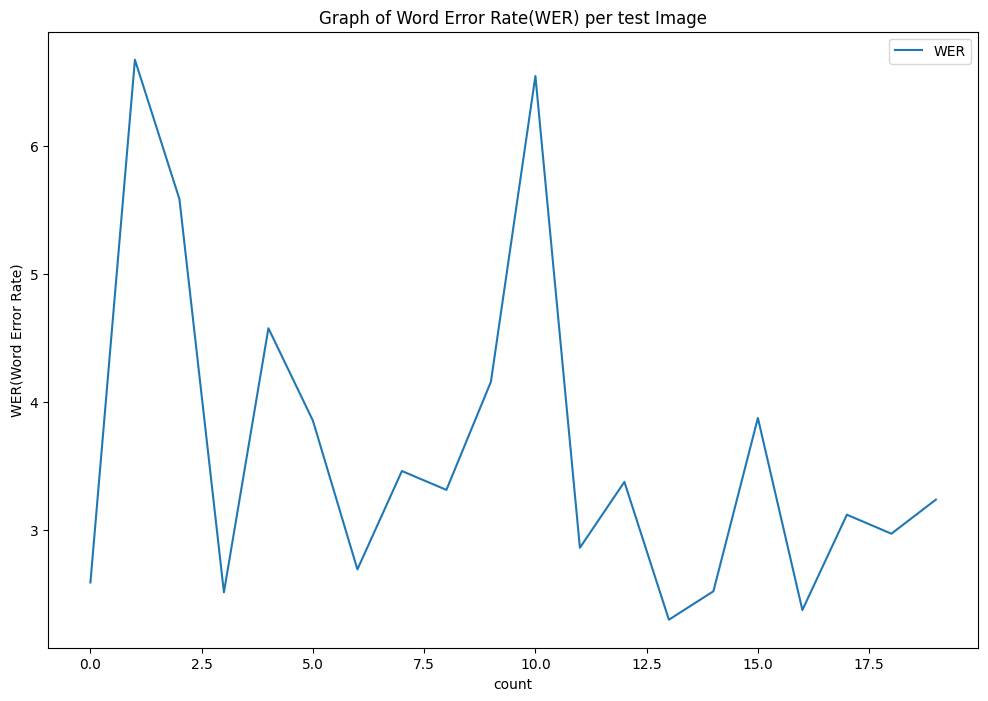

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(wer_list)
plt.title("Graph of Word Error Rate(WER) per test Image")
plt.xlabel("count")
plt.ylabel("WER(Word Error Rate)")
plt.legend(['WER'])
plt.show()


e:\Projects\College Projetcs\Nepali_OCR\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Projects\College Projetcs\Nepali_OCR\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
e:\Projects\College Projetcs\Nepali_OCR\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Projects\College Projetcs\Nepali_OCR\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Projects\College Projetcs\Nepali_OCR\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Projects\College Projetcs\Nepali_OCR\env\lib\site-packages\s

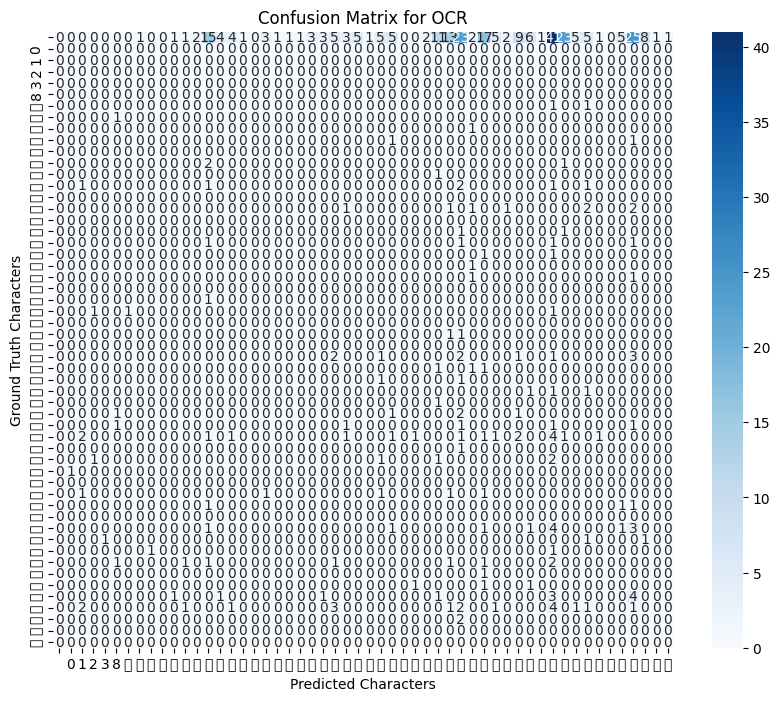

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Example ground truth and predicted text

ground_truth = "संयुक्त र मिश्र वाक्यको प्रयोग गरी आफ्नो भावी योजनाको वर्णन गर्दै एउटा अनुच्छेद तयार गर्नुहोस् जब म ठुलो हुन्छु तब विकास गर्नुपर्छ । म आफ्नो राम्रोसगै वरिपर गाउँ ठाउँ सबैको राम्ररो गर्न चाहान्छु ।"
predictions = ' 1888 11 2 18 30 11 2हुग्रामा राख्या अपना स्माना र मात्रामशुक्ला तरह मिल्ला विश्व याथा गथाउनाका वा वास्त रण्य र र र उँहा। कानुस्तक वायार प्रार्थारी व्युबाबुल स्व कुलोका छुवाई प्रति क्षेत्र को प्रकार का स्थासम् । ठाम्री हुम प्रक्रिलन या या खिले प्रशिक । शिर कि । श्रीव हुद्वामाखा राम्री काम राष्ट्रीय । सिर्माणित किया गरिएकोमानु छोड़ रहिमा कम दिखाका विकास विकास विकास र गर्नुपर्छ । को दिन ति हिंशाई व्यास प्रणार्थ कियघाम्रा राज्य उपायित स्वयुद्ध व्यावादितवावरण वास खाड छाड का व्या विभाग विभाग व्या वर्षीश थित हो। हो। एनायारा०८ ।'

# Step 1: Flatten ground truth and predictions to characters
gt_chars = list(ground_truth.replace(" ", ""))  # Remove spaces
pred_chars = list(predictions.replace(" ", ""))

# Step 2: Pad predictions if lengths mismatch (optional for alignment)
max_len = max(len(gt_chars), len(pred_chars))
gt_chars += [""] * (max_len - len(gt_chars))  # Add empty characters if needed
pred_chars += [""] * (max_len - len(pred_chars))

# Step 3: Generate confusion matrix
labels = sorted(set(gt_chars + pred_chars))  # Unique characters
cm = confusion_matrix(gt_chars, pred_chars, labels=labels)

# Step 4: Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Characters")
plt.ylabel("Ground Truth Characters")
plt.title("Confusion Matrix for OCR")
plt.show()


TypeError: 'float' object is not callable

In [28]:
total_pred_text

[' 1888 11 2 18 30 11 2हुग्रामा राख्या अपना स्माना र मात्रामशुक्ला तरह मिल्ला विश्व याथा गथाउनाका वा वास्त रण्य र र र उँहा। कानुस्तक वायार प्रार्थारी व्युबाबुल स्व कुलोका छुवाई प्रति क्षेत्र को प्रकार का स्थासम् । ठाम्री हुम प्रक्रिलन या या खिले प्रशिक । शिर कि । श्रीव हुद्वामाखा राम्री काम राष्ट्रीय । सिर्माणित किया गरिएकोमानु छोड़ रहिमा कम दिखाका विकास विकास विकास र गर्नुपर्छ । को दिन ति हिंशाई व्यास प्रणार्थ कियघाम्रा राज्य उपायित स्वयुद्ध व्यावादितवावरण वास खाड छाड का व्या विभाग विभाग व्या वर्षीश थित हो। हो। एनायारा०८ ।',
 'PAGE NO. :लाशि , शामीले स्वारे क्या कानु प्रदेशु अवधिमा व्यक्त मा मिस्वर्वी गसरकारी वा यै वर्ष का पर्क पर्धा थो विर्णको ब्रुवार कुल कारखण मुख्यखम्मी ब्राग बनान हेर्नुल हेर्नु गर्छाडी विक्टी कुंडी के स्थामीको विश्व र र विवर को लिक्काम हुन्छ। मन र शाक्या दुर्मावास राष्टन्छिडारामा मुई हिंग । अर्दो वारुणा चुटेनन्छना वा जना र को र के क   २३,नि व्यावश्यका श्री शुरुवारा कार्याला आरोपाल खानुख्या हो । प्रद्र परपर येक कोडी। मिलेज दिया या। समाव को विशाक को बारे बार्डछन् वि